In [29]:
# Import packages and libraries 
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from roc_multiclass import roc_multiclass
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, roc_auc_score, classification_report, accuracy_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import RandomOverSampler
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier

from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, precision_score, roc_curve

In [ ]:
# Load data
df = pd.read_csv("../data/OASIS/oasis_cross-sectional.csv")

In [ ]:
# Define a list for all people under 50
df_below_50 = df.query("Age < 50")

# Drop delay and id
df = df.drop("Delay", axis=1)
df = df.drop("ID", axis=1)

# Fill CDR with 0 and all other missing values with averages from people under 50 (idea trough EDA)
df["CDR"] = df["CDR"].fillna(0)
df["MMSE"] = df["MMSE"].fillna(df_below_50["MMSE"].mean())
df["SES"] = df["SES"].fillna(df_below_50["SES"].mean())
df["Educ"] = df["Educ"].fillna(df_below_50["Educ"].mean())

In [ ]:
# Change value of target variable to be usable for the model
df["CDR"] = df["CDR"].replace(2, 3)
df["CDR"] = df["CDR"].replace(1, 2)
df["CDR"] = df["CDR"].replace(0.5, 1)

In [ ]:
# Create dummies for gender and hand
gender_dummies = pd.get_dummies(df["M/F"])
hand_dummies = pd.get_dummies(df["Hand"])

# Concat dummies with df and create final df
df_final = pd.concat([df.drop(["M/F", "Hand"], axis=1), gender_dummies, hand_dummies], axis=1)

In [ ]:
# Define features and target variable
X = df_final.drop("CDR", axis=1)
y = df_final["CDR"]

# Scale the date
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split into train and test set
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, stratify=y, random_state=1)

# Oversample only on the train set
oversample = RandomOverSampler(sampling_strategy='all', random_state=1)
X_over, y_over = oversample.fit_resample(X_train, y_train)

In [ ]:
# Initiate model and fit training data
rfc_model = RandomForestClassifier(max_depth=10, n_estimators=100, random_state=1, max_features="sqrt")
rfc_model.fit(X_over, y_over)

# Make predictions on test and train set
y_pred_test = rfc_model.predict(X_test)
y_pred_train = rfc_model.predict(X_over)

y_pred_test_prob = rfc_model.predict_proba(X_test)

In [23]:
# Print classification report for test set
print(classification_report(y_test, y_pred_test, zero_division=False))

              precision    recall  f1-score   support

         0.0       0.95      0.88      0.91        84
         1.0       0.48      0.71      0.57        17
         2.0       0.67      0.57      0.62         7
         3.0       0.00      0.00      0.00         1

    accuracy                           0.83       109
   macro avg       0.52      0.54      0.53       109
weighted avg       0.85      0.83      0.83       109



In [24]:
# Print classification report for train set
print(classification_report(y_over, y_pred_train))

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00       252
         1.0       1.00      1.00      1.00       252
         2.0       1.00      1.00      1.00       252
         3.0       1.00      1.00      1.00       252

    accuracy                           1.00      1008
   macro avg       1.00      1.00      1.00      1008
weighted avg       1.00      1.00      1.00      1008



Text(3.1, 4.3, 'Moderate demented')

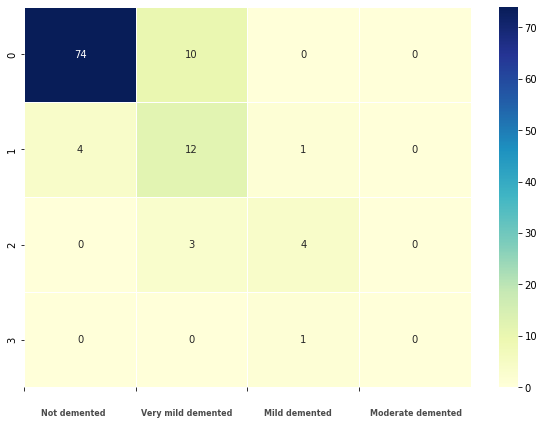

In [78]:
# Evaluate the model with a confusion matrix
cm = confusion_matrix(y_test, y_pred_test)
plt.figure(figsize = (10, 7))
fig1 = sns.heatmap(cm, cmap='YlGnBu', annot=True, fmt='d', linewidths=.5)
fig1.set_xticks([0, 1, 2, 3])
fig1.text(0.15, 4.3,"Not demented", size=8, alpha=0.7, weight="bold")
fig1.text(1.05, 4.3,"Very mild demented", size=8, alpha=0.7, weight="bold")
fig1.text(2.15, 4.3,"Mild demented", size=8, alpha=0.7, weight="bold")
fig1.text(3.1, 4.3,"Moderate demented", size=8, alpha=0.7, weight="bold")

In [ ]:
# onehotencode 

type(y_test)

In [ ]:
y_pred_test_prob.shape

In [ ]:
roc_multiclass(y_pred_test_prob, y_test, ["not_demented", "very_mild", "mild", "moderate"], "macro")